Make that we are running the correct version of TensorFlow first

In [1]:
import tensorflow as tf
tf.__version__

'2.0.0-alpha0'

In [2]:
import sys

assert sys.version_info >= (3, 6) # Python ≥3.6 required
assert tf.__version__ >= "2.0"    # TensorFlow ≥2.0 required

# Emnist lines dataset generator

1. Get sentences from NTLK 
2. Use these sentences to generate line images of 34 characters max, which mean a single image would be of height 28px and width up to 28x34=952px

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sys
# To be able to write code as if this notebook was one level up in files tree structure.
sys.path.append('..')

from pathlib import Path

import tensorflow as tf

import nltk

import json
import itertools
import re
import string
import random

import numpy as np
from PIL import Image
from tqdm import tqdm

In [4]:
from recognizer.datasets import Dataset
from recognizer.datasets import EmnistDataset

In [5]:
NLTK_DATA_DIRNAME = Dataset.raw_data_path() / 'nltk'
NLTK_DATA_DIRNAME

PosixPath('/Users/mostafagazar/Work/notebooks/line-reader/data/raw/nltk')

In [6]:
MAX_LENGTH = 34

## Explore ntlk brown corpus

In [7]:
nltk.data.path.append(NLTK_DATA_DIRNAME)
try:
    nltk.corpus.brown.sents()
except LookupError:
    NLTK_DATA_DIRNAME.mkdir(parents=True, exist_ok=True)
    nltk.download('brown', download_dir=NLTK_DATA_DIRNAME)

sents = nltk.corpus.brown.sents()
sents

[['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.'], ['The', 'jury', 'further', 'said', 'in', 'term-end', 'presentments', 'that', 'the', 'City', 'Executive', 'Committee', ',', 'which', 'had', 'over-all', 'charge', 'of', 'the', 'election', ',', '``', 'deserves', 'the', 'praise', 'and', 'thanks', 'of', 'the', 'City', 'of', 'Atlanta', "''", 'for', 'the', 'manner', 'in', 'which', 'the', 'election', 'was', 'conducted', '.'], ...]

In [8]:
print(f"{len(sents)} sentences available")

57340 sentences available


In [9]:
sentences_length = [len(sentence) for sentence in sents]

print(f"Min sentence length is {min(sentences_length)}")

print(f"Median sentence length is {np.median(sentences_length)}")
print(f"Mean sentence length is {np.mean(sentences_length)}")

print(f"Max sentence length is {max(sentences_length)}")

Min sentence length is 1
Median sentence length is 18.0
Mean sentence length is 20.250994070456922
Max sentence length is 180


In [10]:
sentences_greater_than_max_length = sum(length > MAX_LENGTH for length in sentences_length)
print(f"There are {sentences_greater_than_max_length} sentences greater than max length")

There are 7459 sentences greater than max length


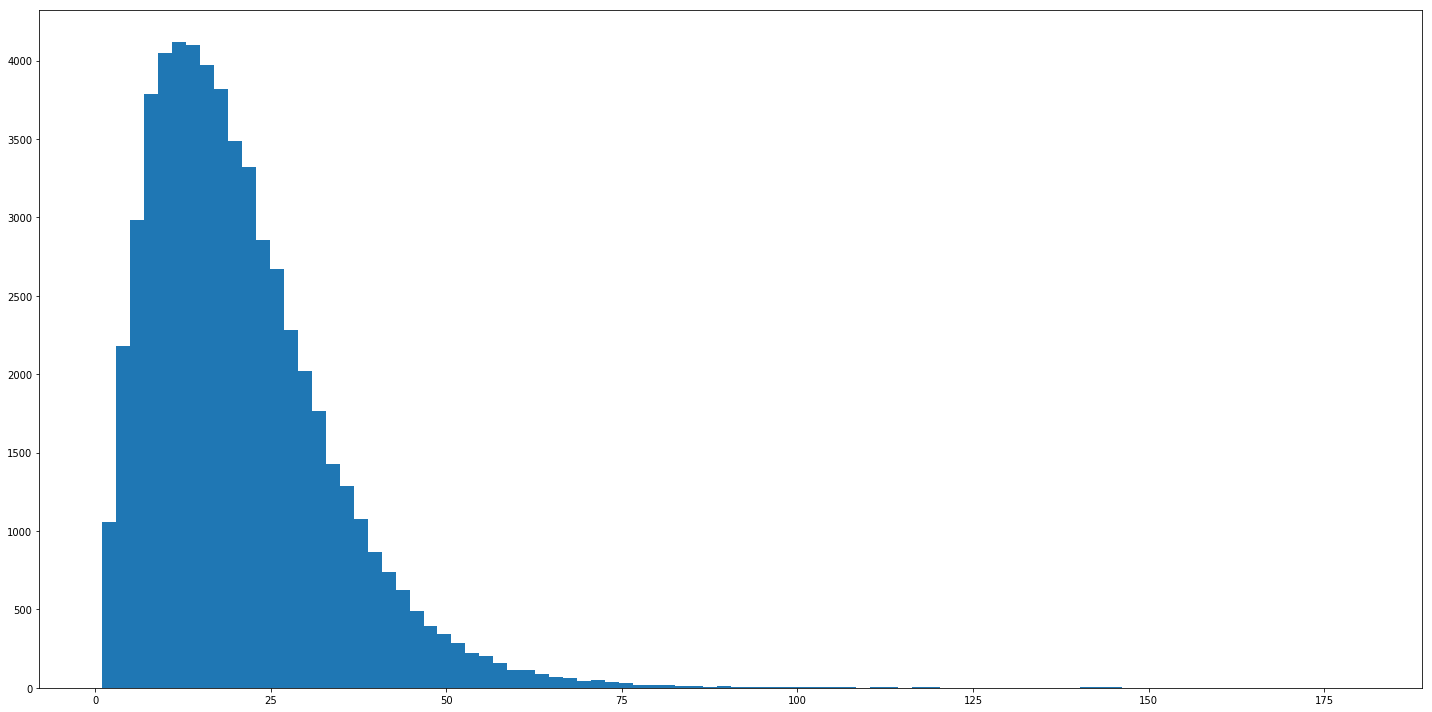

In [11]:
fig = plt.figure(figsize=(20, 10))

plt.hist(sentences_length, bins=90)
fig.tight_layout()

## Convert sentence words array to text

In [12]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [13]:
corpus = []
punctuation_dict = {ord(c): None for c in string.punctuation}

for sentence in sents:
    # Merge sentence
    text = ' '.join(sentence)
    # Remove punctuation
    text = text.translate(punctuation_dict)
    # Replace multiple spaces with one.
    text = re.sub('  +', ' ', text)
    
    corpus.append(text)
    
corpus[:3]

['The Fulton County Grand Jury said Friday an investigation of Atlantas recent primary election produced no evidence that any irregularities took place ',
 'The jury further said in termend presentments that the City Executive Committee which had overall charge of the election deserves the praise and thanks of the City of Atlanta for the manner in which the election was conducted ',
 'The SeptemberOctober term jury had been charged by Fulton Superior Court Judge Durwood Pye to investigate reports of possible irregularities in the hardfought primary which was won by Mayornominate Ivan Allen Jr ']

## Generate dataset

In [14]:
random.seed(32)

dataset_length = 10000
random_indices = random.sample(range(0, len(corpus) - 1), dataset_length)

y = []
for index in random_indices:
    sentence = ""
    for word in corpus[index].split(" "):
        if len(sentence) + len(word) < MAX_LENGTH:
            sentence += word + " "
        else:
            break
            
    padding = "_" * (MAX_LENGTH - len(sentence))
    y.append(sentence + padding)
    
y[:3]

['Whats wrong at state _____________',
 'The transducer itself moves the __',
 'There is an ancient and venerable ']

### Get random image letter

In [15]:
with open(f"{Dataset.raw_data_path()}/emnist/emnist_essentials.json") as json_file:  
    mapping = json.load(json_file)["mapping"]
    mapping = {m[0]: m[1] for m in mapping}
    
print(f"Number of classes: {len(mapping)}")

Number of classes: 62


In [16]:
emnist_dataset = EmnistDataset()
print(f"Number of classes: {emnist_dataset.number_of_classes}")
print(f"mean: {emnist_dataset.mean}, std: {emnist_dataset.std}")

Download path: /Users/mostafagazar/Work/notebooks/line-reader/data/cache/datasets/matlab.zip
Processing data...
Balancing train dataset...
Target max number of images per class: 21635892
Dataset ready, with 1395864 training entries and 116323 test entries
Number of classes: 62
mean: 44.2650032043457, std: 84.56700134277344


#### Train and test dataset shapes

In [17]:
emnist_dataset.train_dataset._tensors[0].shape

TensorShape([1395864, 28, 28, 1])

In [18]:
emnist_dataset.test_dataset._tensors[0].shape

TensorShape([116323, 28, 28, 1])

#### Get a random image from emnist dataset

Image shape: (28, 28, 1), label: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Text(0.5, 1.0, 'label: J')

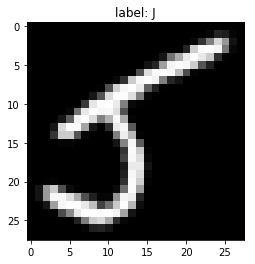

In [19]:
(image, label), = emnist_dataset.train_dataset.shuffle(1024).take(1)
# Convert the label tensor to numpy array and then get its Python scalar value.
print(f"Image shape: {image.shape}, label: {label}")

plt.imshow(image.numpy().reshape(28, 28), cmap='gray')
plt.title(f"label: {mapping[label.numpy().argmax()]}")

#### Create a dictionary to use for serving random images to the line generator

In [20]:
sampling_dict = {}
for image, label_hot_encoded in emnist_dataset.train_dataset:
    label = mapping[label_hot_encoded.numpy().argmax()]
    if label in sampling_dict:
        sampling_dict[label].append(image.numpy().reshape(28, 28))
    else:
        sampling_dict[label] = [image]

In [21]:
len(sampling_dict)

62

Handle padding and space chars

In [22]:
zero_image = np.zeros((28, 28), np.uint8)

sampling_dict[' '] = [zero_image]
sampling_dict['_'] = [zero_image]

In [23]:
len(sampling_dict)

64

## Generate images from this corpus

In [24]:
emnist_lines_dataset_path = Dataset.processed_data_path()/'emnist_lines'
emnist_lines_dataset_path.mkdir(parents=True, exist_ok=True)

In [25]:
lines_images = []
lines_sentences = []

for i, sentence in enumerate(tqdm(y)):
    letter_samples_for_string = []
    for char in sentence:
        char_index = random.randint(0, len(sampling_dict[char]) - 1)
        char_image = sampling_dict[char][char_index]
        letter_samples_for_string.append(char_image)
    
    image_name = f"{str(i)}.png"

    # Constract line image from sampled characters.
    overlap = 0 # Simple no overalps for now.
    N = len(letter_samples_for_string)
    H, W = letter_samples_for_string[0].shape
    next_overlap_width = W - int(overlap * W)
    concatenated_image = np.zeros((H, W * N))
    x = 0
    for image in letter_samples_for_string:
        concatenated_image[:, x:(x + W)] += image
        x += next_overlap_width
    line_image = np.minimum(255, concatenated_image)

    # Debug
#     plt.imshow(line_image, cmap='gray')
    
    # Save image with i as id
    img = Image.fromarray(line_image.astype(np.uint8), "L")
    img.save(f"{emnist_lines_dataset_path/image_name}")

    lines_images.append(image_name)
    lines_sentences.append(y)
#     break

  0%|          | 19/10000 [00:00<00:52, 189.97it/s]


ValueError: could not broadcast input array from shape (28,28,28) into shape (28,28)

#### Load it in a dataframe and save it

In [ ]:
lines_dataset_dict = {'image': lines_images, 'sentence': lines_sentences}
df = pd.DataFrame(data=lines_dataset_dict)

In [ ]:
df.head()

In [ ]:
df.to_csv(Dataset.data_path/"processed"/"emnist_lines", index=False)